# Feature Importance

In [1]:
import json
import pandas as pd
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent.parent))
from models.encoder.common import METRICS_DIR

FEATURE_NAME_MAPPING = {
    "extract_word_length_by_char": "Word Length",
    "extract_ngram_word_length_by_char": "Word Length Trigram",
    "extract_sentence_length_by_word": "Sentence Length",
    "extract_char_ngrams": "Character N-Gram Frequency",
    "extract_punctuation": "Punctuation Frequency",
    "extract_pos_frequency": "Morphological POS Frequency",
    "extract_pos_ngrams": "Morphological POS N-Gram Frequency",
    "extract_dependency_tree_structure": "Dependency Tree Structure",
    "extract_dependency_tree_relations": "Dependency Tree N-Gram Frequency",
    "extract_casing": "Casing-Position Frequency",
    "extract_casing_bigrams": "Casing Bigram Frequency",
    "extract_ttr": "Type-Token Ratio (TTR)",
    "extract_lexical_density": "Lexical Density",
    "extract_sentence_length_by_word_avg": "Sentence Length Average",
    "extract_syllable_count_avg": "Syllable Count Average",
    "extract_3+syllable_count_ratio": "3+ Syllable Word Ratio",
    "extract_stopwords": "Stopword Ratio",
    "extract_noun_phrase_lengths": "Noun Phrase Frequency",
    "extract_supersense": "Supersense Frequency",
    "extract_entity_categories": "Named Entity Frequency",
    "extract_events": "Event Ratio",
    "extract_places": "Place Ratio",
    "extract_tense": "Tense Ratio",
    "extract_numeric_word_ratio": "Numeric Word Ratio",
    "extract_quote_ratio": "Quote Ratio",
    "extract_contractions": "Contraction Ratio",
    "extract_articles": "Article Ratio",
    "extract_word_concreteness": "Word Concreteness Frequency",
    "extract_word_concreteness_avg": "Word Concreteness Average",
    "extract_preposition_imageability": "Preposition Imageability Frequency",
    "extract_preposition_imageability_avg": "Preposition Imageability Average",
    "extract_polysemy": "Polysemy Frequency",
}


def load_metrics(pattern):
    """Load and average metrics from JSON files matching the pattern."""
    files = list((METRICS_DIR / "feature-importance").glob(pattern))
    if not files:
        return None
    all_metrics = []
    for filepath in files:
        with open(filepath, "r") as f:
            metrics = json.load(f)
            all_metrics.append(metrics)
    if not all_metrics:
        return None
    # Average the metrics
    averaged = {}
    keys = ["mse", "accuracy", "f1"]
    for key in keys:
        if key == "f1":
            # Average element-wise
            f1_lists = [m.get("f1", []) for m in all_metrics]
            if f1_lists and all(len(lst) == len(f1_lists[0]) for lst in f1_lists):
                averaged["f1"] = [sum(x) / len(f1_lists) for x in zip(*f1_lists)]
            else:
                averaged["f1"] = []
        else:
            values = [m.get(key, 0) for m in all_metrics]
            averaged[key] = sum(values) / len(values) if values else 0
    return averaged


# Load baseline (all features)
baseline_metrics = load_metrics("catboost_minilm_catboost-minilm-s*_test_*.json")

# Load features only (no embeddings)
features_only_metrics = load_metrics("catboost_minilm_features-minilm-s*_test_*.json")

# Load metrics for each removed feature group
removed_group_metrics = {}
for group in FEATURE_NAME_MAPPING.keys():
    metrics = load_metrics(f"catboost_minilm_features-{group}-s*_test_*.json")
    removed_group_metrics[group] = metrics

print(f"Loaded baseline metrics: {baseline_metrics is not None}")
print(f"Loaded features-only metrics: {features_only_metrics is not None}")
print(
    f"Loaded {sum(1 for m in removed_group_metrics.values() if m is not None)}/{len(FEATURE_NAME_MAPPING)} removed group metrics"
)

# Debug: print averaged values
if baseline_metrics:
    print(
        f"Baseline averaged MSE: {baseline_metrics['mse']:.4f}, Accuracy: {baseline_metrics['accuracy']:.4f}"
    )
if features_only_metrics:
    print(
        f"Features-only averaged MSE: {features_only_metrics['mse']:.4f}, Accuracy: {features_only_metrics['accuracy']:.4f}"
    )

/home/terra/Projects/vis-desc/modules/lab/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded baseline metrics: True
Loaded features-only metrics: True
Loaded 32/32 removed group metrics
Baseline averaged MSE: 0.7396, Accuracy: 0.5013
Features-only averaged MSE: 0.7432, Accuracy: 0.4885


In [2]:
import math

rows = []


def macro_f1(m):
    return sum(m["f1"]) / len(m["f1"]) if m else None


baseline_macro_f1 = None
if baseline_metrics:
    baseline_rmse = math.sqrt(baseline_metrics["mse"])
    baseline_macro_f1 = macro_f1(baseline_metrics)
    rows.append(
        {
            "Removed": "None – Baseline",
            "RMSE": baseline_rmse,
            "Accuracy": baseline_metrics["accuracy"],
            "Macro Avg F1": baseline_macro_f1,
        }
    )

if features_only_metrics:
    features_only_rmse = math.sqrt(features_only_metrics["mse"])
    rows.append(
        {
            "Removed": "MiniLM embeddings",
            "RMSE": features_only_rmse,
            "Accuracy": features_only_metrics["accuracy"],
            "Macro Avg F1": macro_f1(features_only_metrics),
        }
    )

for group in FEATURE_NAME_MAPPING.keys():
    metrics = removed_group_metrics[group]
    if metrics:
        human_name = FEATURE_NAME_MAPPING.get(
            group, group.replace("extract_", "").replace("_", " ").title()
        )
        rows.append(
            {
                "Removed": human_name,
                "RMSE": math.sqrt(metrics["mse"]),
                "Accuracy": metrics["accuracy"],
                "Macro Avg F1": macro_f1(metrics),
            }
        )

df = pd.DataFrame(rows)

if baseline_metrics:
    baseline_acc = baseline_metrics["accuracy"]
    baseline_rmse_val = math.sqrt(baseline_metrics["mse"])
    baseline_macro_f1_val = baseline_macro_f1
    df["RMSE Δ"] = df["RMSE"] - baseline_rmse_val
    df["Accuracy Δ"] = df["Accuracy"] - baseline_acc
    df["Macro F1 Δ"] = df["Macro Avg F1"] - baseline_macro_f1_val
else:
    df["RMSE Δ"] = float("nan")
    df["Accuracy Δ"] = float("nan")
    df["Macro F1 Δ"] = float("nan")

df = df.sort_values("RMSE", ascending=True).reset_index(drop=True)

ordered_cols = [
    "Removed",
    "RMSE",
    "RMSE Δ",
    "Accuracy",
    "Accuracy Δ",
    "Macro Avg F1",
    "Macro F1 Δ",
]
df = df[ordered_cols]

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")


def highlight_baselines(row):
    config = row["Removed"]
    if "Baseline" in config:
        return ["font-weight: bold;"] * len(row)
    return [""] * len(row)


vmin_rmse = df["RMSE"].min()
vmax_rmse = df["RMSE"].max()

styled_df = (
    df.style.format(
        {
            "RMSE": "{:.4f}",
            "RMSE Δ": "{:.4f}",
            "Accuracy": "{:.4f}",
            "Accuracy Δ": "{:.4f}",
            "Macro Avg F1": "{:.4f}",
            "Macro F1 Δ": "{:.4f}",
        }
    )
    .apply(highlight_baselines, axis=1)
    .background_gradient(
        subset=["RMSE"], cmap="RdYlGn_r", vmin=vmin_rmse, vmax=vmax_rmse
    )
)

styled_df

,Removed,RMSE,RMSE Δ,Accuracy,Accuracy Δ,Macro Avg F1,Macro F1 Δ
0,Dependency Tree Structure,0.8538,-0.0062,0.5076,0.0064,0.4980,0.0019
1,Dependency Tree N-Gram Frequency,0.8540,-0.0060,0.4847,-0.0165,0.4770,-0.0192
2,Numeric Word Ratio,0.8542,-0.0058,0.5305,0.0293,0.5204,0.0242
3,Noun Phrase Frequency,0.8546,-0.0054,0.5127,0.0115,0.5057,0.0095
4,Event Ratio,0.8557,-0.0043,0.5089,0.0076,0.5019,0.0058
5,Sentence Length,0.8591,-0.0009,0.5102,0.0089,0.5049,0.0087
6,Casing-Position Frequency,0.8599,-0.0001,0.5076,0.0064,0.4999,0.0037
7,None – Baseline,0.8600,0.0000,0.5013,0.0000,0.4962,0.0000
8,Word Length Trigram,0.8608,0.0008,0.5076,0.0064,0.5006,0.0045
9,Morphological POS Frequency,0.8615,0.0015,0.4962,-0.0051,0.4889,-0.0073


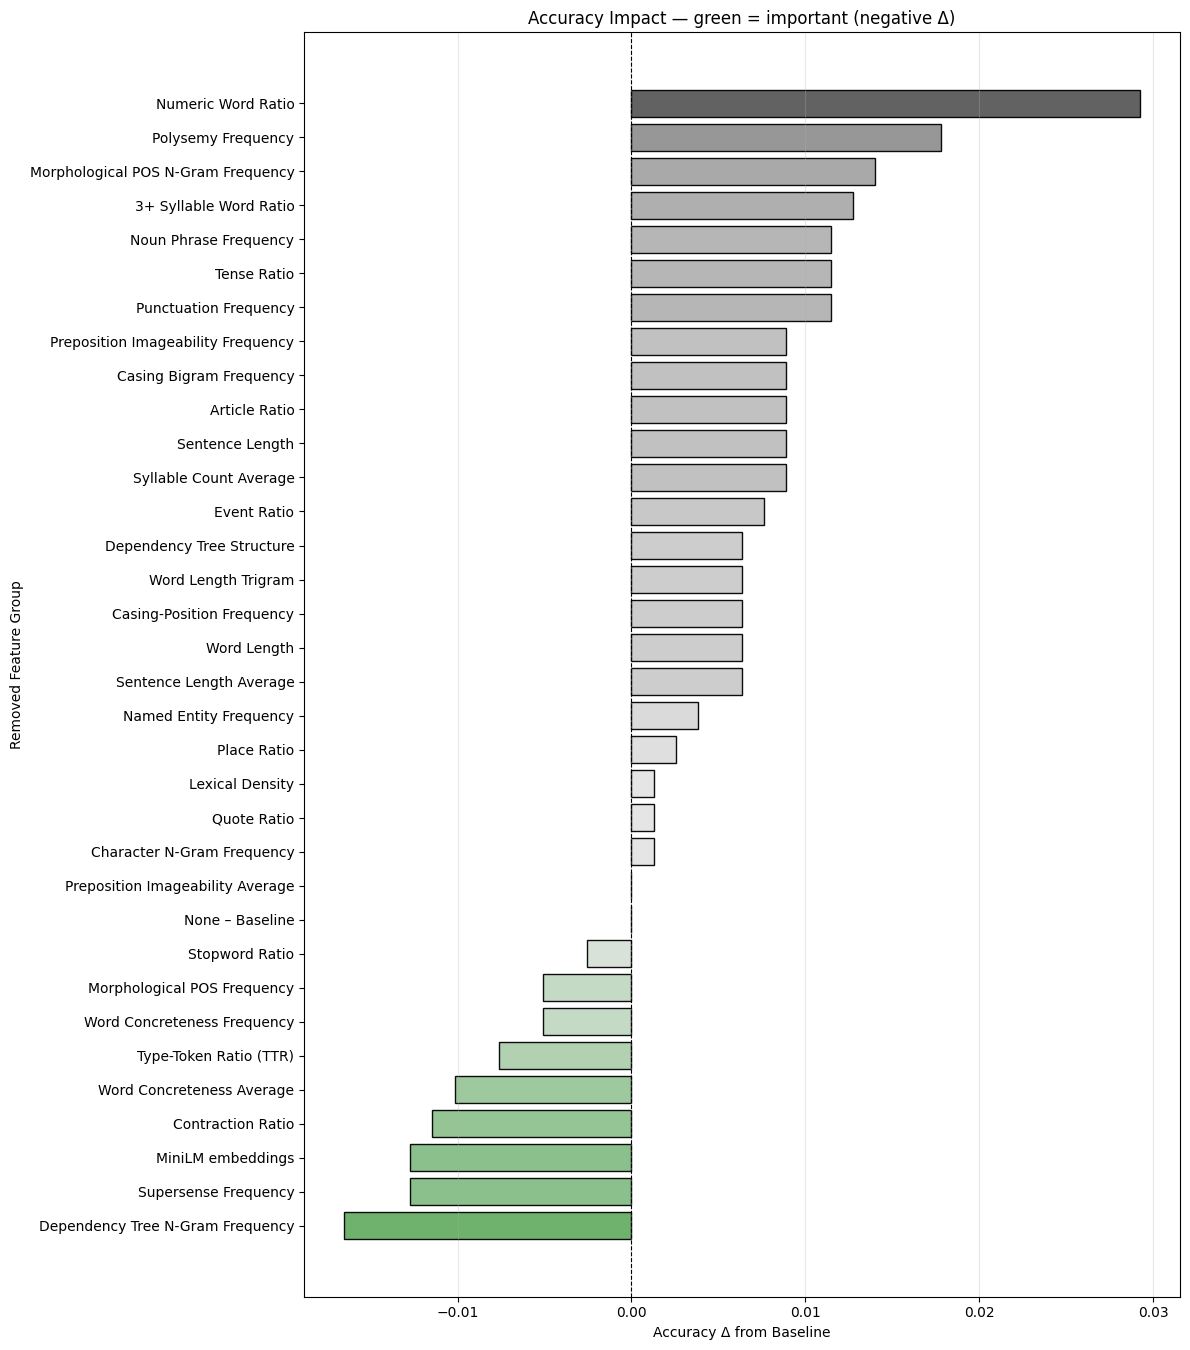

Saved accuracy delta plot -> data/figures/feature_importance_accuracy_delta.png


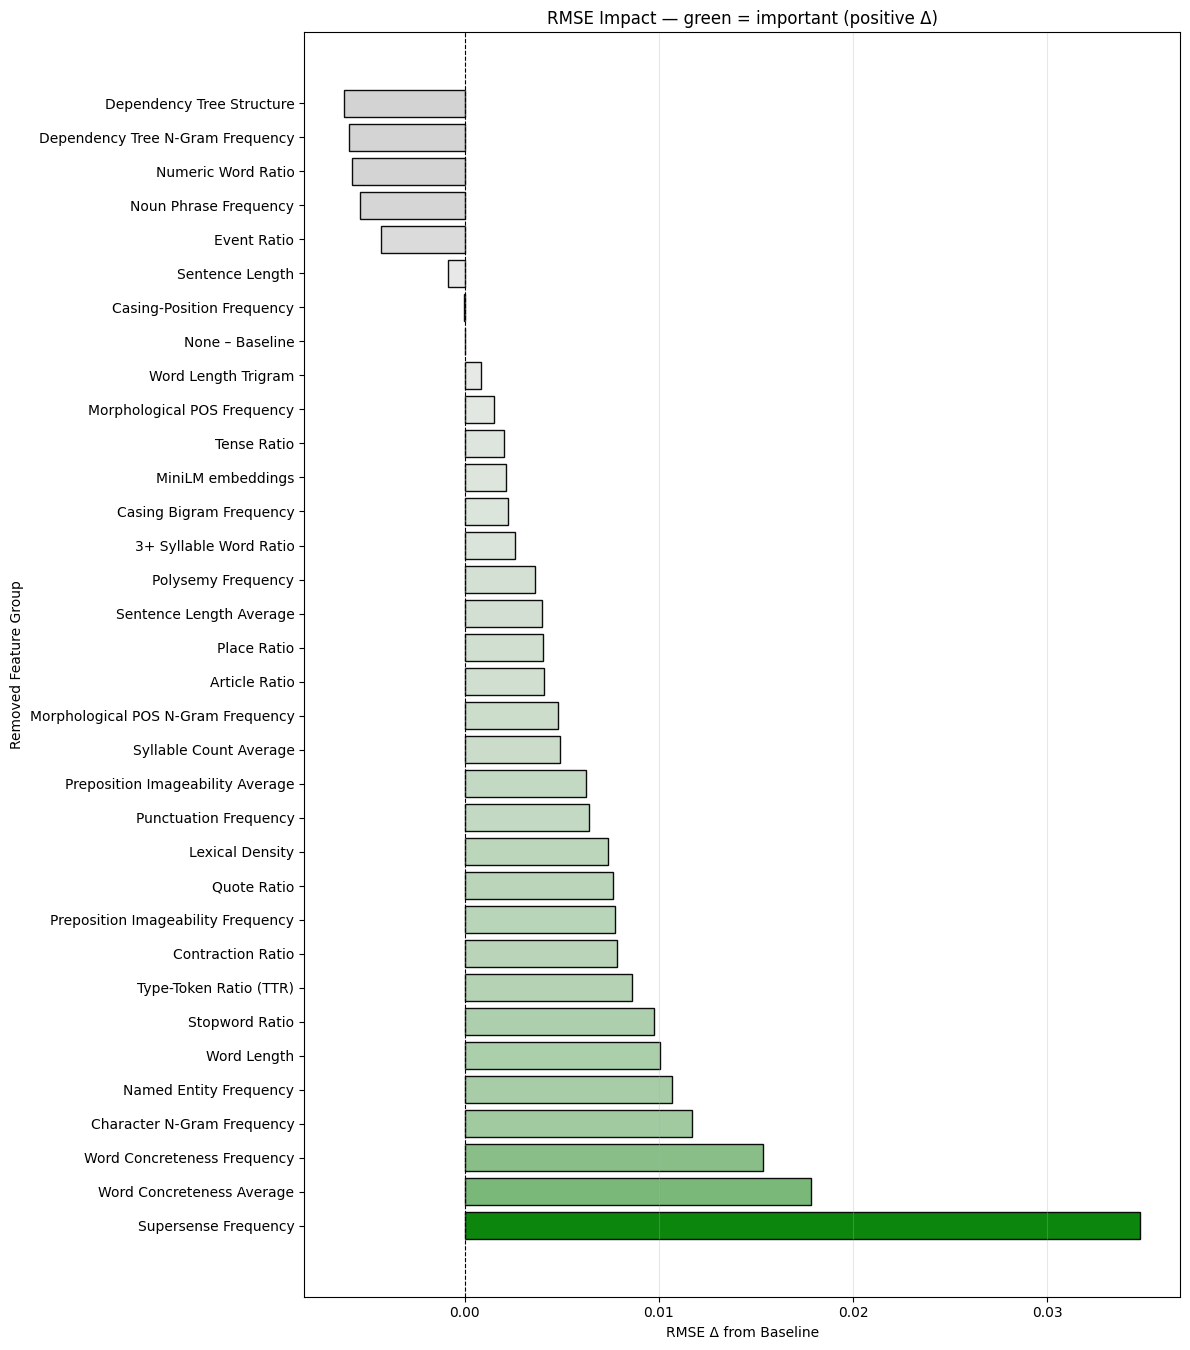

Saved RMSE delta plot -> data/figures/feature_importance_rmse_delta.png


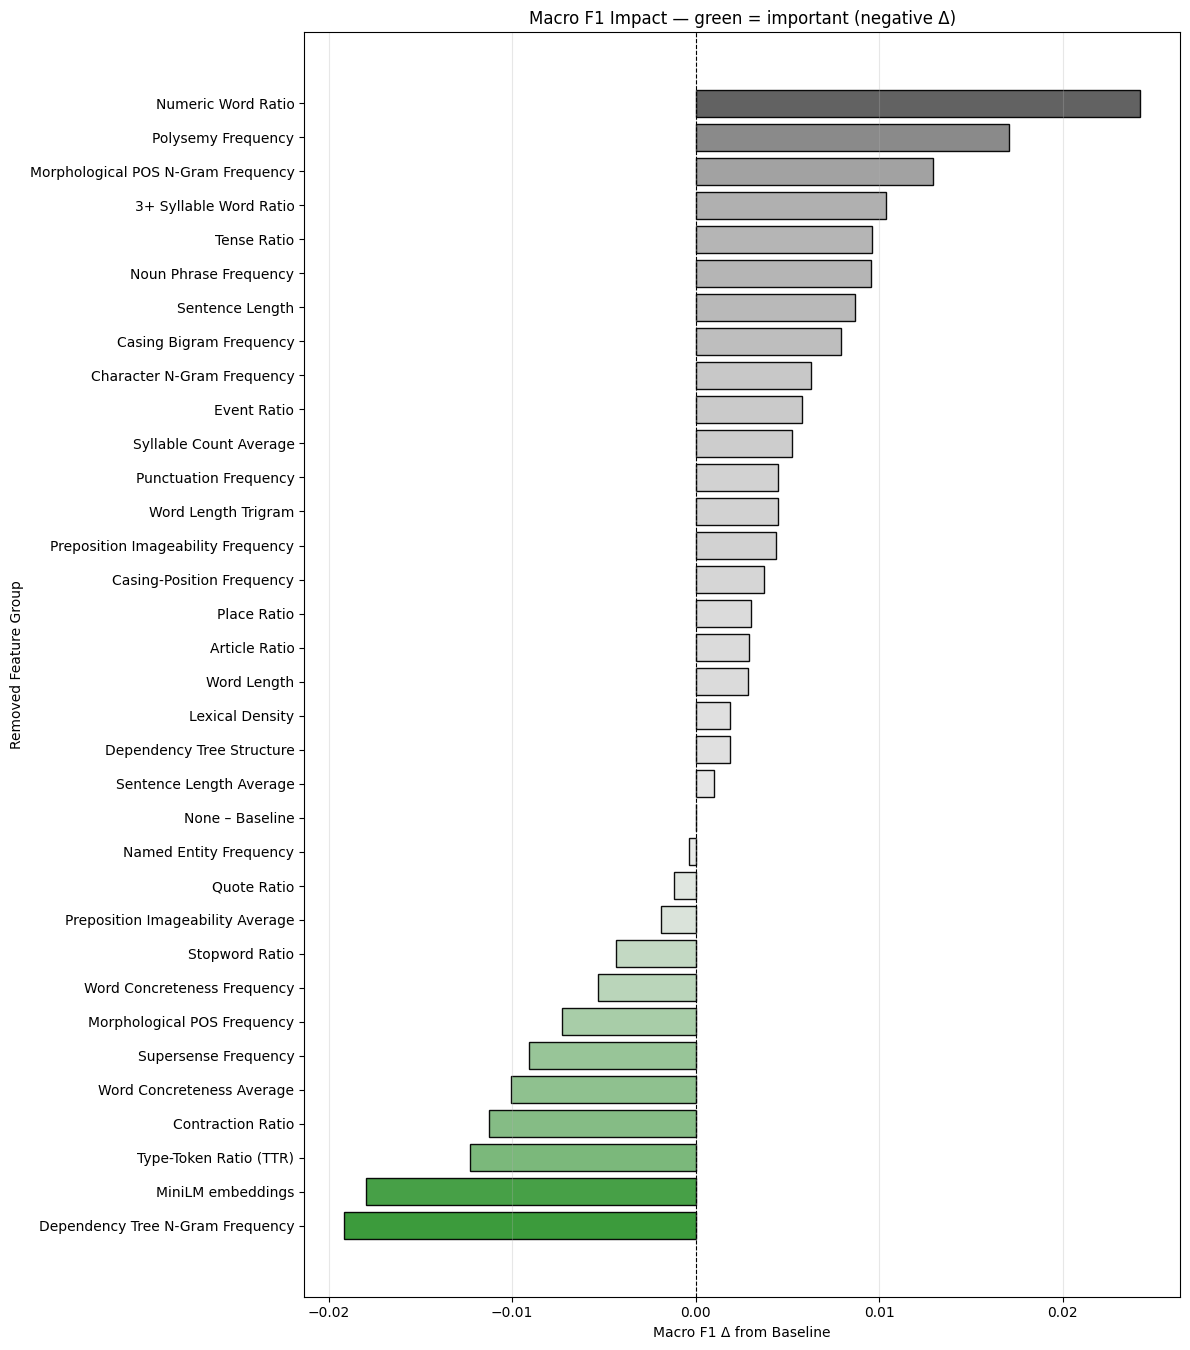

Saved Macro F1 delta plot -> data/figures/feature_importance_macro_f1_delta.png


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare DataFrame
plot_df = df.copy()
plot_df["Feature"] = plot_df["Removed"]


# Interpolate between two RGB colors
def interp_color(a, b, t):
    return tuple(float(a[i] + (b[i] - a[i]) * t) for i in range(3))


# Build colors based on absolute importance magnitude and whether the sign indicates "important"
# - important entries: base_gray -> green (more important => more green/saturated)
# - not-important entries: base_gray -> dark_gray (less useful => darker/desaturated)
def importance_colors(
    deltas,
    important_mask,
    base_gray=(0.92, 0.92, 0.92),
    green=(0.0, 0.5, 0.0),
    dark_gray=(0.35, 0.35, 0.35),
):
    abs_imp = np.abs(deltas.astype(float))
    max_imp = abs_imp.max()
    if max_imp <= 0:
        max_imp = 1.0
    colors = []
    for val, imp_flag, mag in zip(deltas, important_mask, abs_imp):
        t = mag / max_imp
        if imp_flag:
            colors.append(interp_color(base_gray, green, t))
        else:
            colors.append(interp_color(base_gray, dark_gray, t))
    return colors


# 1) Accuracy: negative Δ = important
acc_sorted = plot_df.sort_values("Accuracy Δ")
acc_deltas = acc_sorted["Accuracy Δ"]
acc_mask = acc_deltas < 0
colors_acc = importance_colors(acc_deltas, acc_mask)
plt.figure(figsize=(12, max(6, 0.4 * len(acc_sorted))))
plt.barh(
    acc_sorted["Feature"],
    acc_sorted["Accuracy Δ"],
    color=colors_acc,
    alpha=0.95,
    edgecolor="black",
)
plt.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
plt.xlabel("Accuracy Δ from Baseline")
plt.ylabel("Removed Feature Group")
plt.title("Accuracy Impact — green = important (negative Δ)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig(
    "/home/terra/Projects/vis-desc/modules/lab/data/figures/feature_importance_accuracy_delta.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("Saved accuracy delta plot -> data/figures/feature_importance_accuracy_delta.png")

# 2) RMSE: positive Δ = important
rmse_sorted = plot_df.sort_values("RMSE Δ", ascending=False)
rmse_deltas = rmse_sorted["RMSE Δ"]
rmse_mask = rmse_deltas > 0
colors_rmse = importance_colors(rmse_deltas, rmse_mask)
plt.figure(figsize=(12, max(6, 0.4 * len(rmse_sorted))))
plt.barh(
    rmse_sorted["Feature"],
    rmse_sorted["RMSE Δ"],
    color=colors_rmse,
    alpha=0.95,
    edgecolor="black",
)
plt.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
plt.xlabel("RMSE Δ from Baseline")
plt.ylabel("Removed Feature Group")
plt.title("RMSE Impact — green = important (positive Δ)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig(
    "/home/terra/Projects/vis-desc/modules/lab/data/figures/feature_importance_rmse_delta.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("Saved RMSE delta plot -> data/figures/feature_importance_rmse_delta.png")

# 3) Macro F1: negative Δ = important
macro_sorted = plot_df.sort_values("Macro F1 Δ")
macro_deltas = macro_sorted["Macro F1 Δ"]
macro_mask = macro_deltas < 0
colors_macro = importance_colors(macro_deltas, macro_mask)
plt.figure(figsize=(12, max(6, 0.4 * len(macro_sorted))))
plt.barh(
    macro_sorted["Feature"],
    macro_sorted["Macro F1 Δ"],
    color=colors_macro,
    alpha=0.95,
    edgecolor="black",
)
plt.axvline(x=0, color="black", linestyle="--", linewidth=0.8)
plt.xlabel("Macro F1 Δ from Baseline")
plt.ylabel("Removed Feature Group")
plt.title("Macro F1 Impact — green = important (negative Δ)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.savefig(
    "/home/terra/Projects/vis-desc/modules/lab/data/figures/feature_importance_macro_f1_delta.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
print("Saved Macro F1 delta plot -> data/figures/feature_importance_macro_f1_delta.png")

## Key Findings

The results suggest that syntactic and semantic features (dependency trees, supersense) are most valuable, while some surface-level features like numeric word ratios may introduce noise.